### Generate Datasets

download mcx, from https://github.com/fangq/mcx.git

go to src dir and run $make

Download nightly version of mcxlab (http://mcx.space/nightly/), overwriting the default one.

Go to mcxlab folder, open matlab.

Run the following scripts to generate image (in mat format) in mcxlab folder.

* genImage_osa_1e5_to_1e8.m
* genImage_osa_1e9.m (10x1e8 and take average, as the clean image)
* genImage_osa_1e5_TestingSet.m (100 testing dataset for 1e5 simulation)

Example Link:
* https://github.com/3upperm2n/mcx_ImageDenoising/blob/master/data/genImage_osa_1e5_to_1e8.m



##### generating data sets used in OSA ( in matlab)

```matlab
%% generating data sets used in OSA

clear all

% Top-level Dir
topFolderName='osa_data';
if ~exist('osa_data', 'dir')  mkdir(topFolderName); end

N = 100; % run N times simulation for each test, 
x = 100;
y = 100;
z = 100;
time = zeros(N,5);
pho_cnt = [1e5, 1e6, 1e7, 1e8];  % use 10 x 1e8 for 1e9 (as the ground truth)
volume = uint8(ones(x,y,z));


for k=1:4
	% Generate new random seed for Monte Carlo simulation
	rand_seed = randi([1 2^31-1], 1, N);
	
	if (length(unique(rand_seed)) < length(rand_seed)) ~= 0
		error('There are repeated random seeds!')
	end

	dir_phn = sprintf('./%s/%1.0e', topFolderName, pho_cnt(k));
    
    if ~exist(dir_phn, 'dir')  mkdir(dir_phn); end

	for tid =1:N
		dir_phn_test = sprintf('%s/%d', dir_phn, tid);
        
        if ~exist(dir_phn_test, 'dir')  mkdir(dir_phn_test); end

		clear cfg
		cfg.nphoton=pho_cnt(k);
		cfg.vol= volume;
		cfg.srcpos=[50 50 1];
		cfg.srcdir=[0 0 1];
		cfg.gpuid=1;
		% cfg.gpuid='11'; % use two GPUs together
		cfg.autopilot=1;
		cfg.prop=[0 0 1 1;0.005 1 0 1.37];
		cfg.tstart=0;
		cfg.tend=5e-8;
		cfg.tstep=5e-8;
		cfg.seed = rand_seed(tid); % each random seed will have different pattern 

		% calculate the flux distribution with the given config
		[flux,detpos]=mcxlab(cfg);

		image3D=flux.data;

		%%% export each image in 3D volume
		for imageID=1:y
			fname = sprintf('%s/osa_phn%1.0e_test%d_img%d.mat', dir_phn_test, pho_cnt(k), tid, imageID);
			fprintf('Generating %s\n',fname);
			currentImage = squeeze(image3D(:,imageID,:));
			feval('save', fname, 'currentImage');

		end
	end
end

```

### plot image 1 and image 50 along the y-axis

In [1]:
from IPython.display import Image

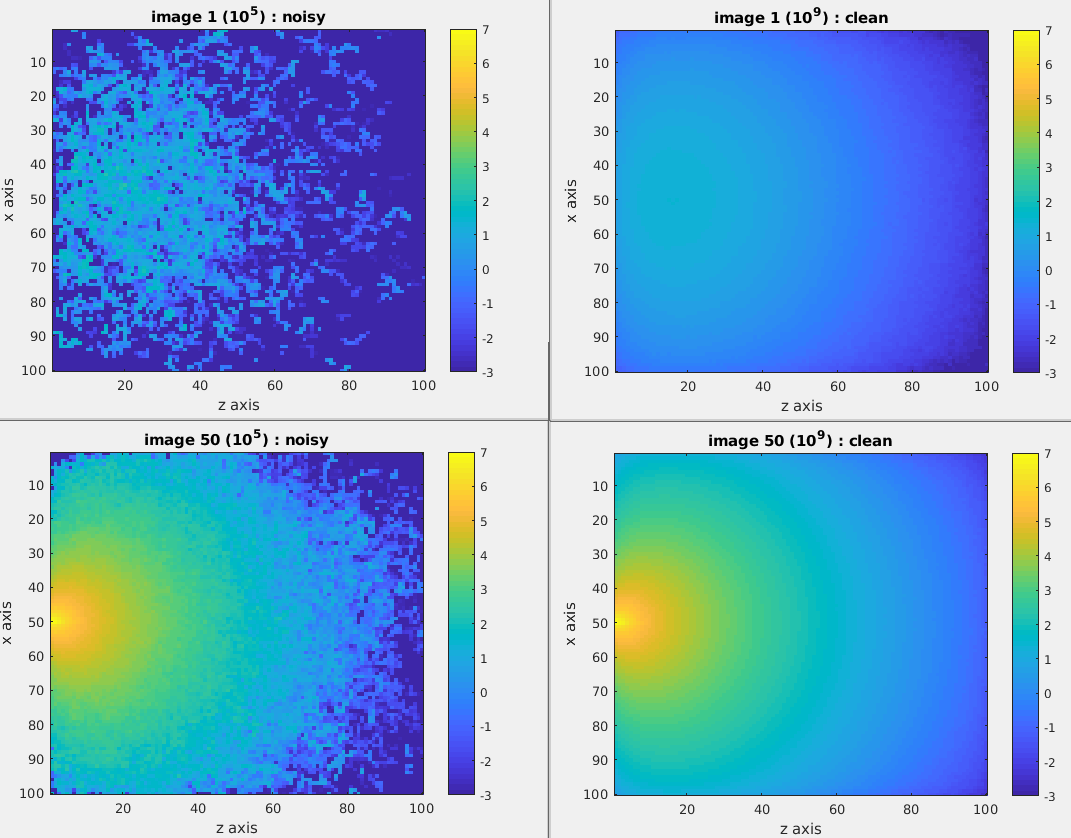

In [2]:
Image("figs/1e5_and_clean.png")

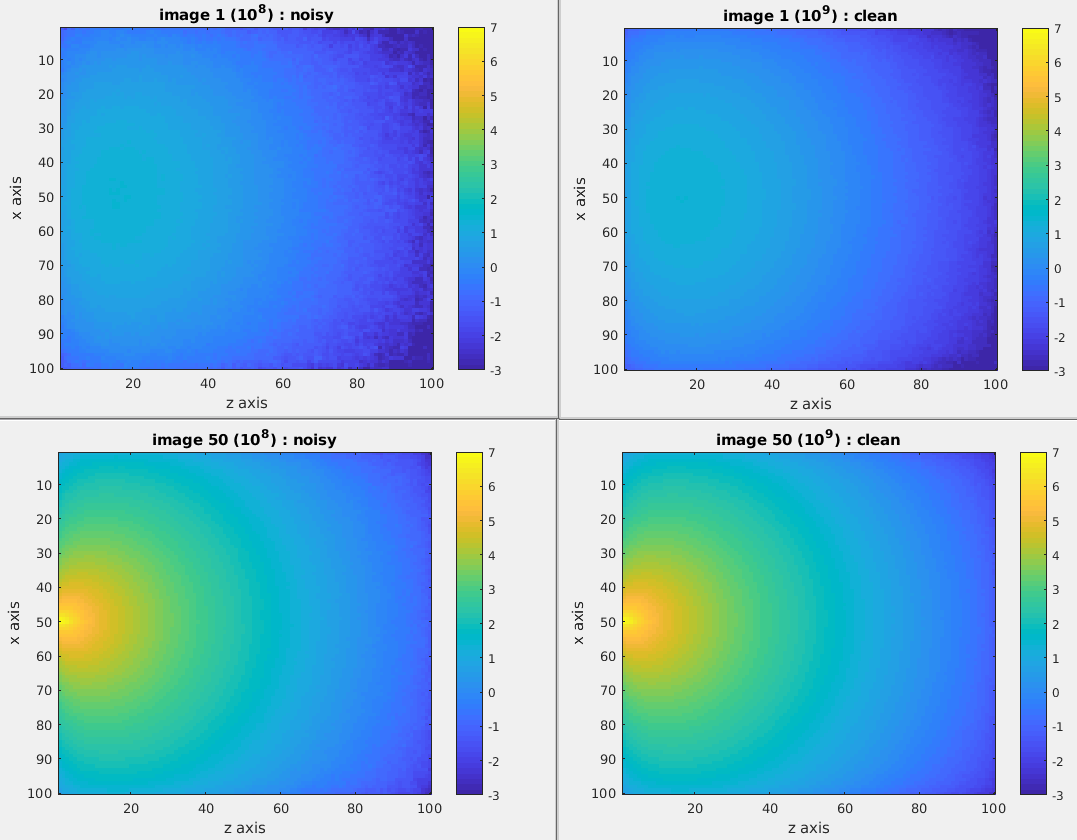

In [3]:
Image("figs/1e8_and_clean.png")

##### About image data

```matlab
1e5 image 1
min = 0.000000e+00, max =2.333029e+02

1e5 image 50
min = 0.000000e+00, max =1.890174e+07

1e8 image 1
min = 3.547600e-08, max =2.521179e+01

1e8 image 50
min = 1.921826e-03, max =7.144604e+06
```

### Current Model : DnCNN

dncnn
* https://github.com/crisb-DUT/DnCNN-tensorflow

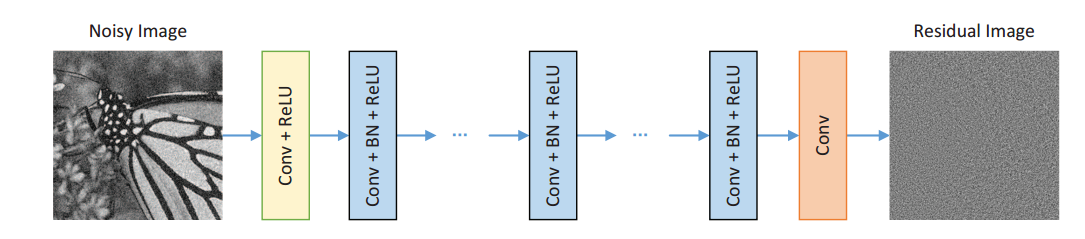

In [4]:
Image("figs/model_figure.png")

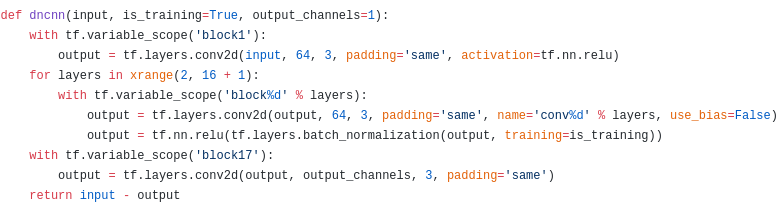

In [8]:
Image("figs/dncnn_model.png")

### DnCNN performance

* training using 1e5 simulation results as the noisy images
* training using 1e8 x 10 avegerage results as the clean images
* build 1e5model for image denoising

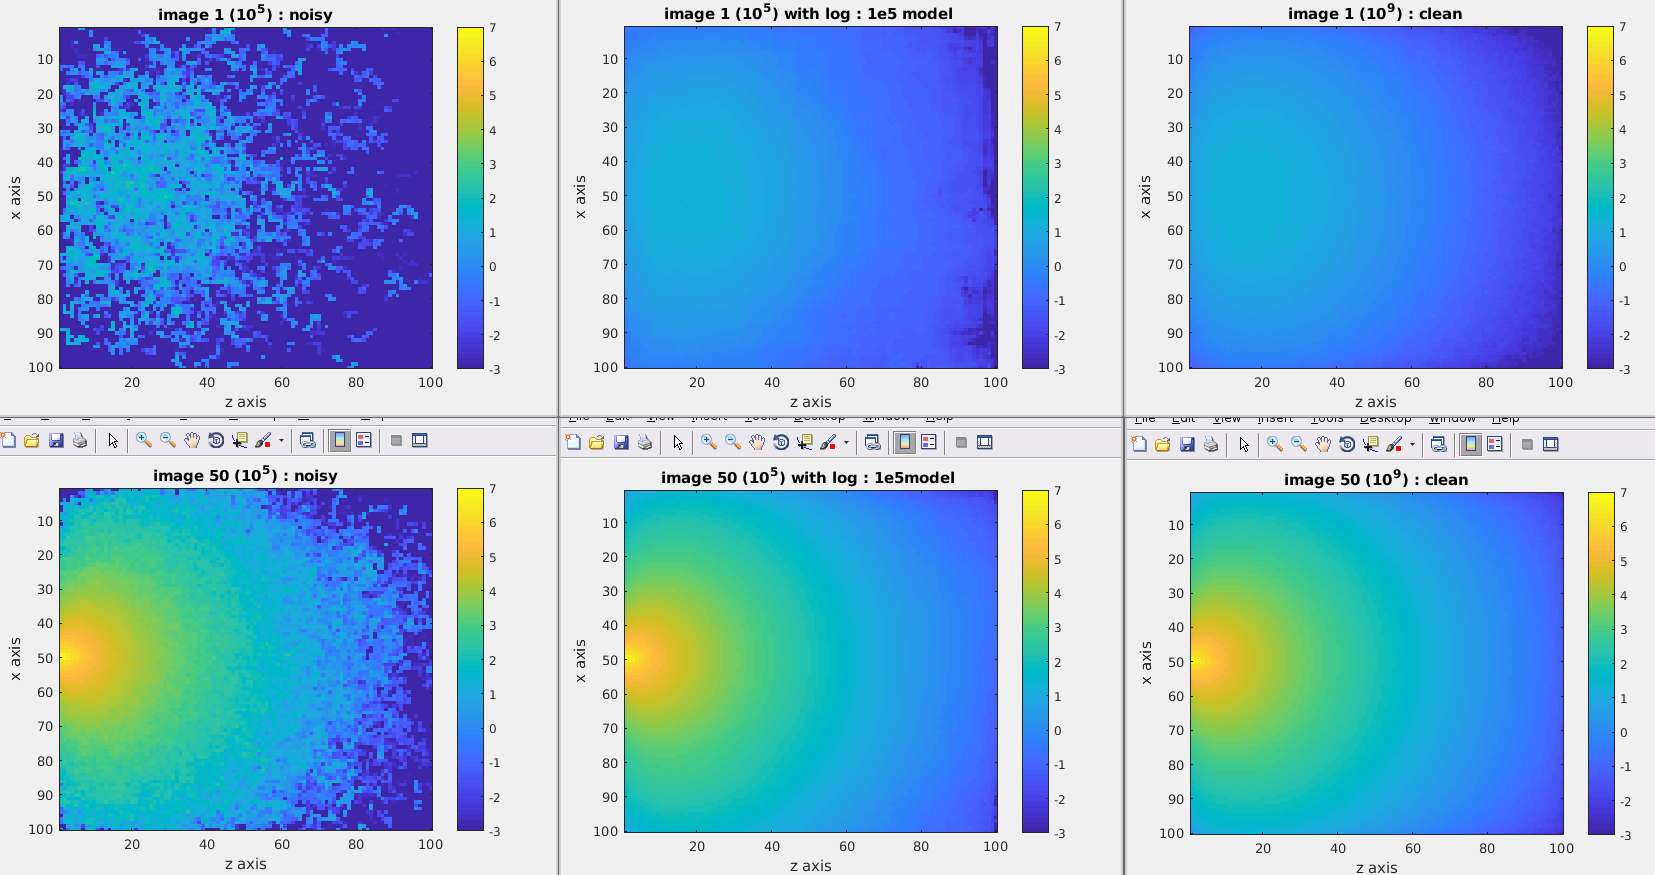

In [11]:
Image("figs/preview-lightbox-1e5model_TestOn_1e5.png")

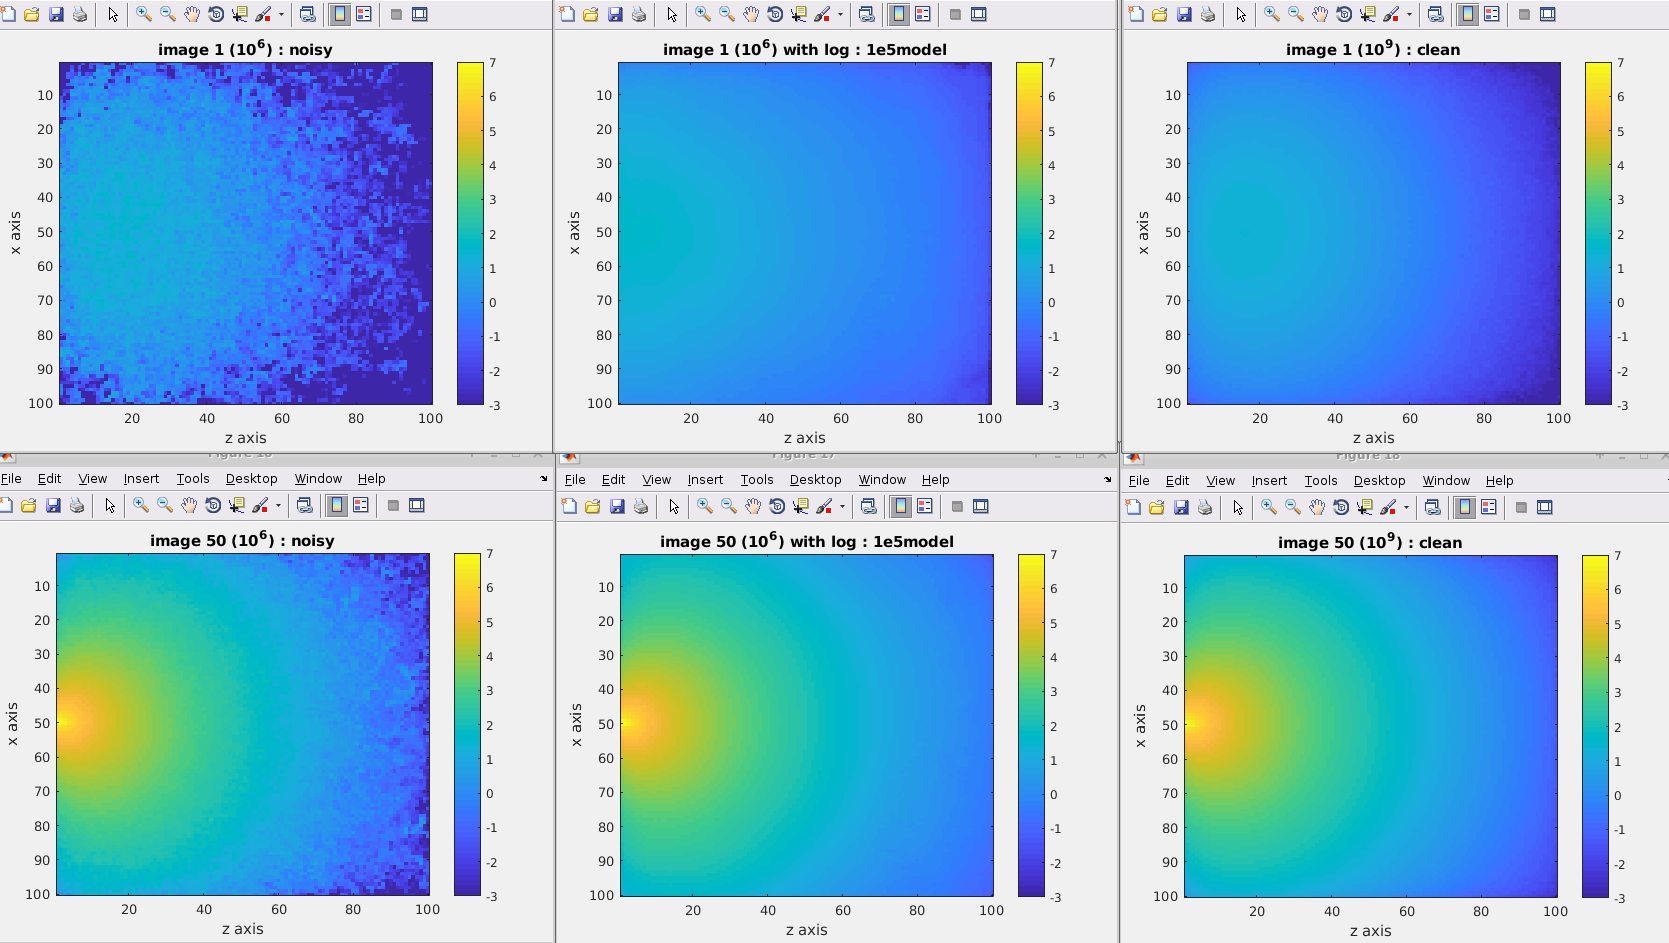

In [12]:
Image("figs/preview-lightbox-1e5model_TestOn_1e6.png")

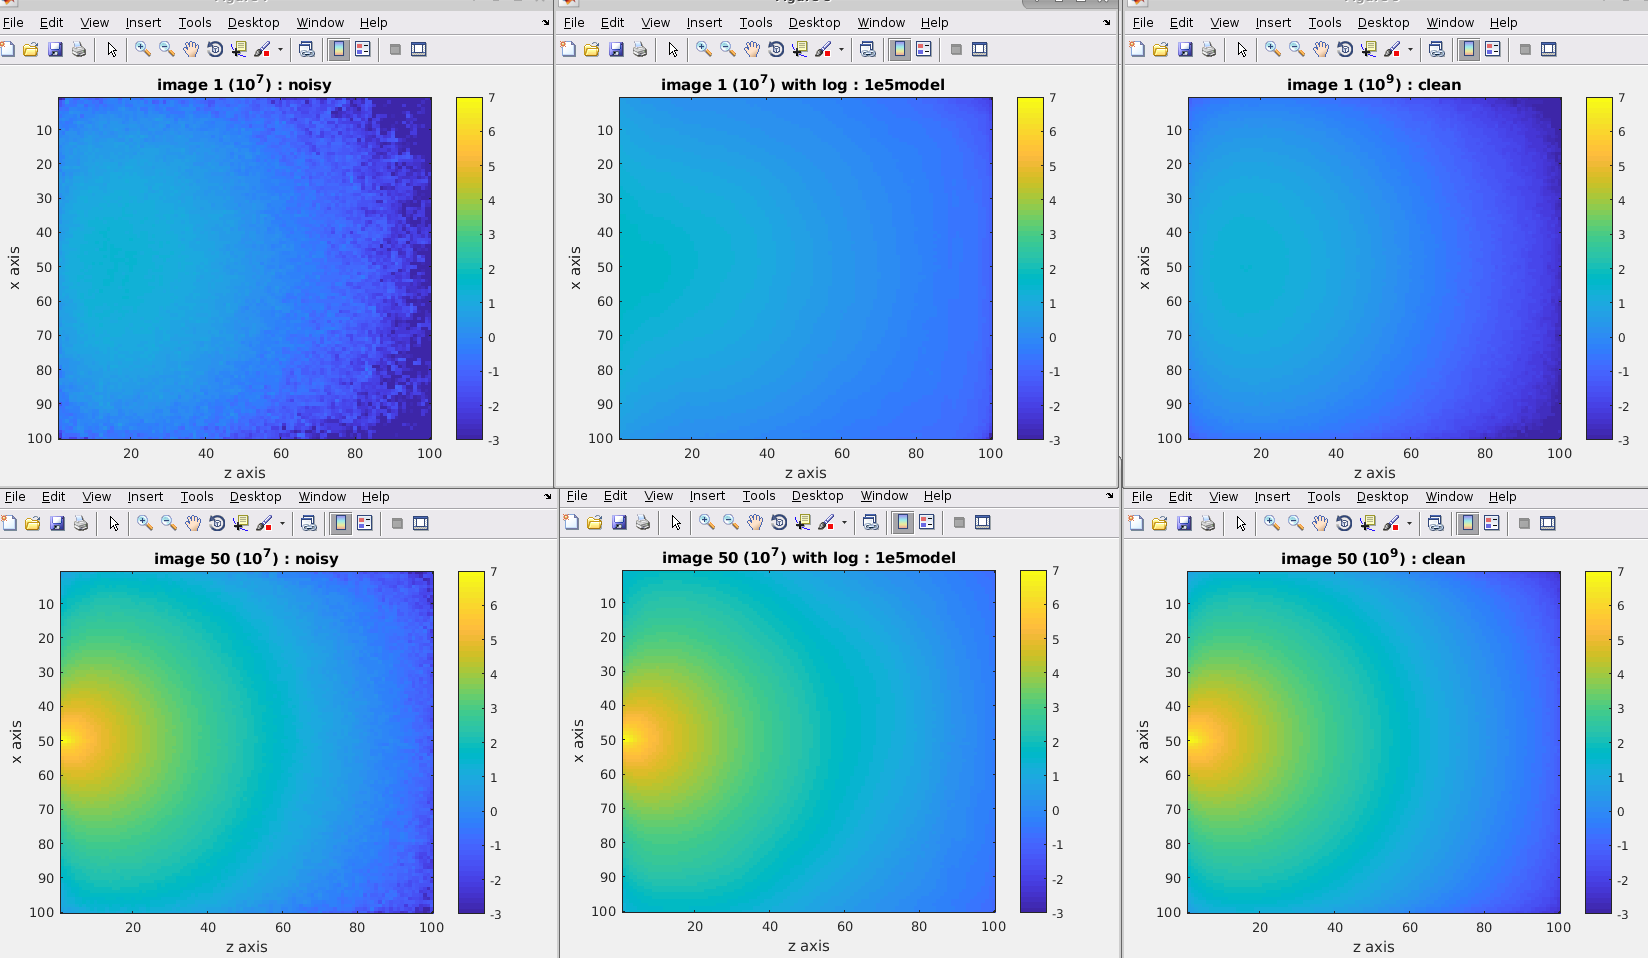

In [13]:
Image("figs/preview-lightbox-1e5model_TestOn_1e7.png")

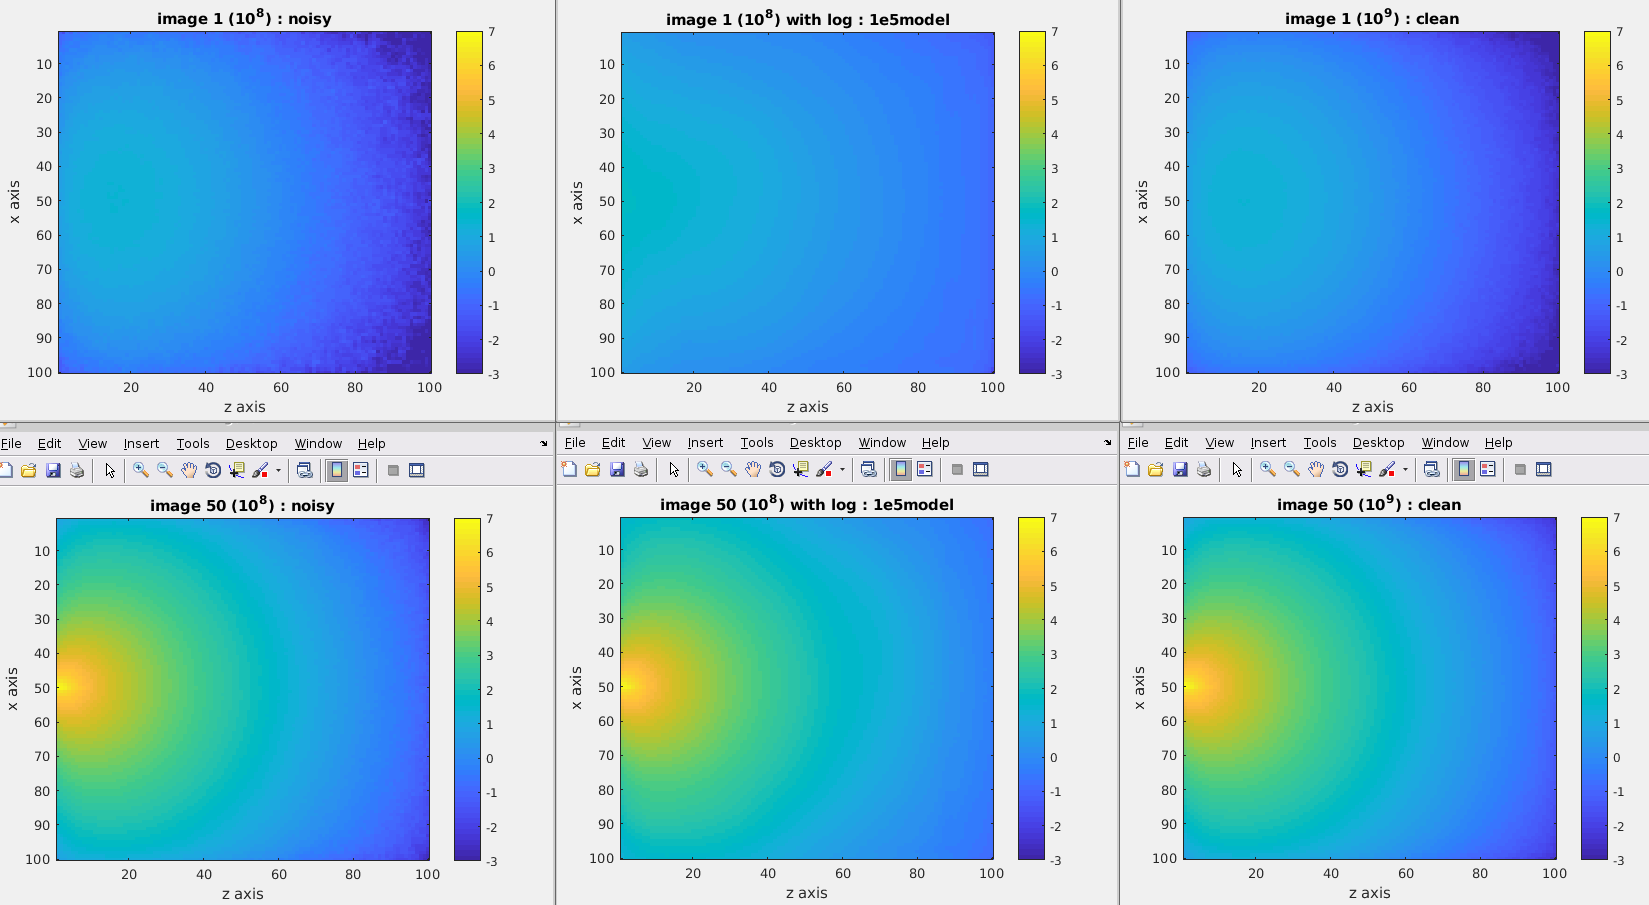

In [14]:
Image("figs/preview-lightbox-1e5model_TestOn_1e8.png")

##### with inclusion

```matlab
cfg.vol=ones(100,100,100);
cfg.vol(40:60,40:60,20:50)=2;
cfg.prop=[0 0 1 1; 0.01, 1, 0, 1.3; 0.1 2 0 1.3];
```

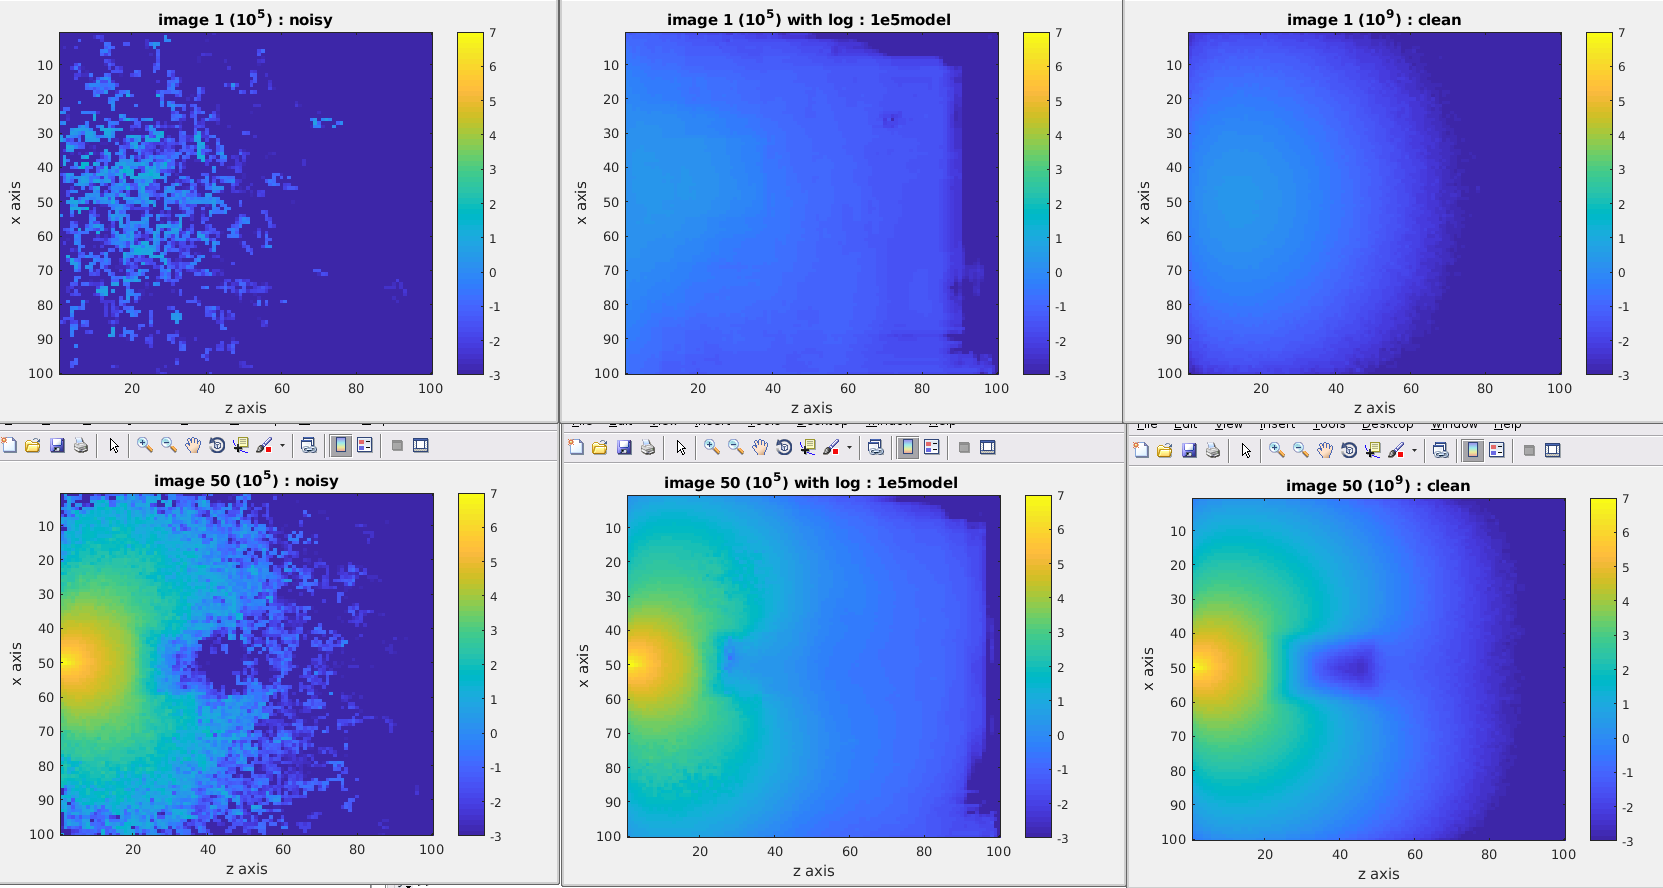

In [15]:
Image("figs/preview-lightbox-1e5model_TestOn_1e5_inclusion.png")

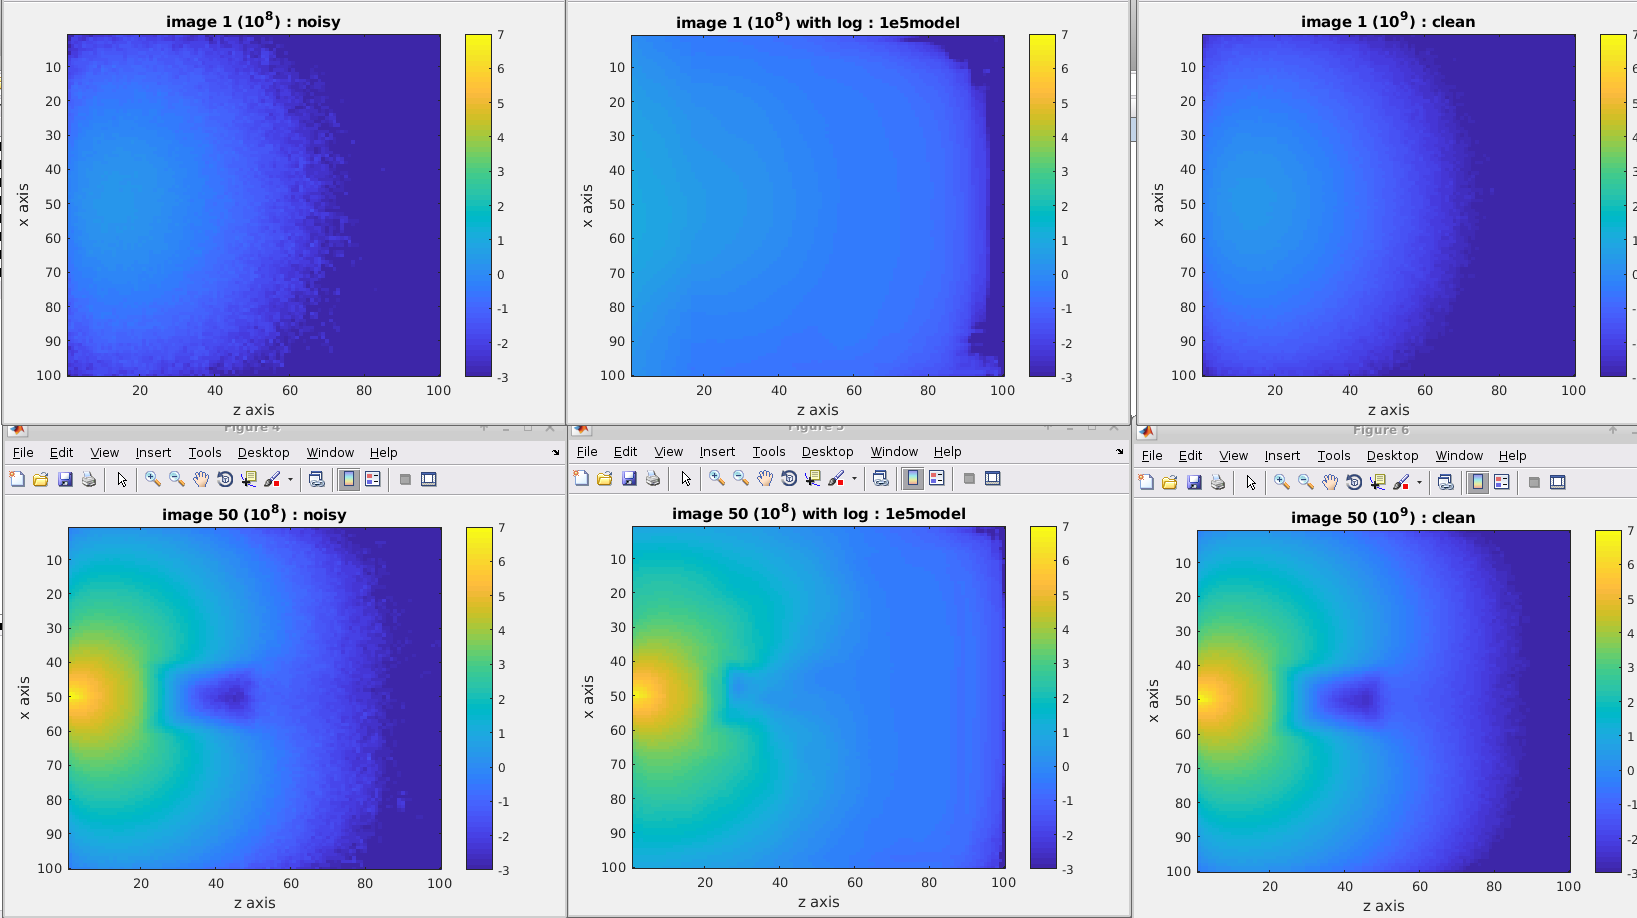

In [16]:
Image("figs/preview-lightbox-1e5model_TestOn_1e8_inclusion.png")

### Adaptive Nonlocal mean Filter

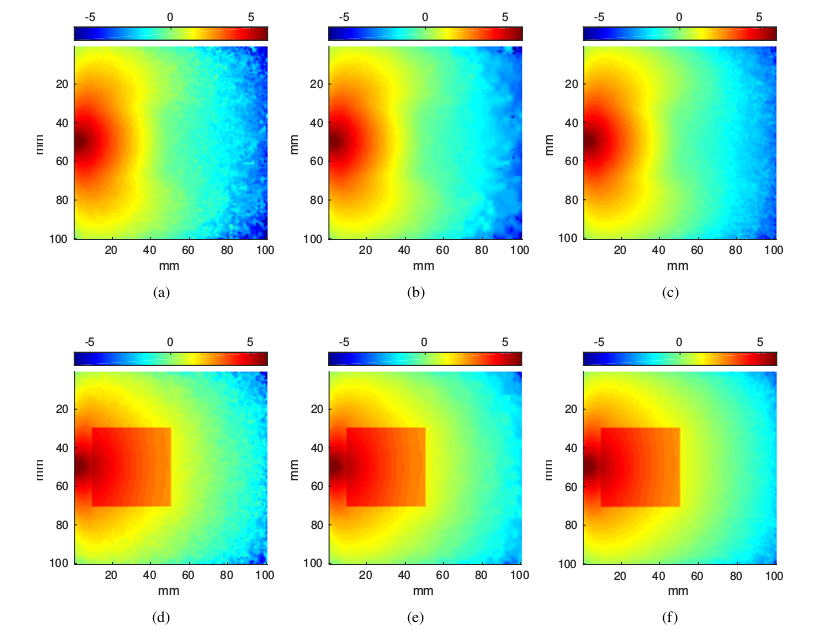

In [17]:
Image("figs/anlm_demo.png")

From left to right, top to bottom, (a) shows the image with absorbing inclusion for
$10^7$ photons; (b) is the filtered image of (a) using GPU ANLM ; (c) shows the image with
absorbing inclusion using $10^8$ photons; (d) is the image with refractive inclusion for 10^7
photons; (e) shows the filtered image of (d); (f) is the image with refractive inclusion for $10^8$
photons. All the images above are obtained by taking log 10 .

##### evaluation

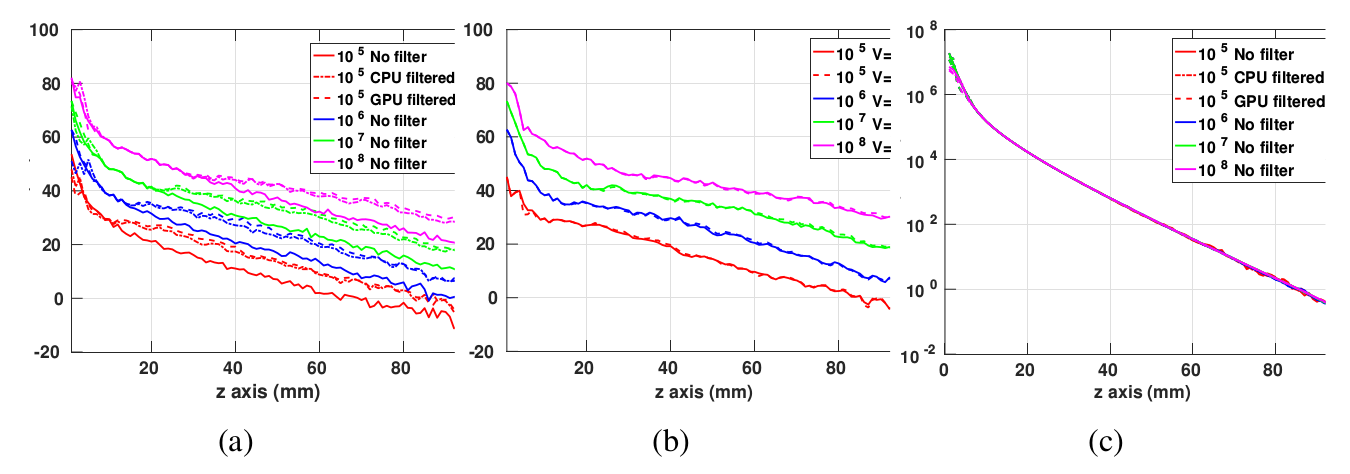

In [18]:
Image("figs/anlm_eval.png")

(a) shows the SNR trend in dB for different photon counts and filters in the
homogeneous volume. (b) shows the SNR trend for search size V = 3 and V = 5 GPU filter.
(c) demonstrate the mean value trend in a $log_{10}$ scale for different photon counts before and
after filtering in the homogeneous volume